In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Assuming DehazingDataset is imported and properly defined
from dataloader import DehazingDataset

In [2]:
def show_images(images, title):
    """Utility function for displaying images in a grid."""
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.title(title)
        plt.axis('off')
    plt.show()

In [5]:
from torch.utils.data.dataloader import default_collate

def collate_fn(batch):
    """ Custom collate function for handling None or varying size tensor batching """
    batch = [{k: v for k, v in d.items() if v is not None} for d in batch]  # Filter out None items if any
    keys = batch[0].keys()
    return {key: default_collate([d[key] for d in batch]) if key != 'bboxes' else [d[key] for d in batch] for key in keys}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch of original images shape: torch.Size([4, 3, 640, 640])
Batch of foggy images shape: torch.Size([4, 3, 640, 640])
Bounding boxes (sample): [[2.0, 0.48473143577575684, 0.44642677903175354, 0.2534775733947754, 0.18753844499588013, 0.8987270593643188], [0.0, 0.9314654469490051, 0.4854241907596588, 0.08848226070404053, 0.46569937467575073, 0.8218747973442078], [0.0, 0.8532228469848633, 0.44692111015319824, 0.05414772033691406, 0.3930802345275879, 0.7791967391967773], [26.0, 0.8363990783691406, 0.44537270069122314, 0.02398073673248291, 0.06635293364524841, 0.5290865898132324], [26.0, 0.9054290056228638, 0.3904886245727539, 0.04966789484024048, 0.19530043005943298, 0.4793339669704437], [26.0, 0.8478314280509949, 0.4306880831718445, 0.04723167419433594, 0.37751373648643494, 0.30531376600265503], [9.0, 0.328241765499115, 0.2241477072238922, 0.03348687291145325, 0.20755769312381744, 0.26367872953414917]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


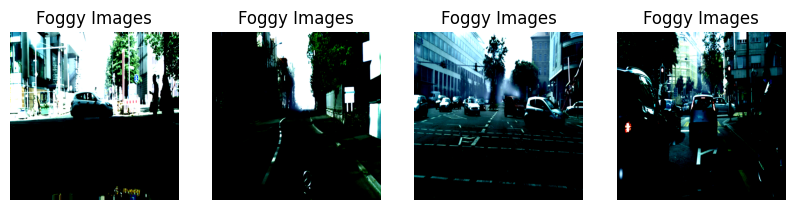

In [8]:
def test_dataloader():
    transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor()
    ])

    dataset = DehazingDataset('/home/stu12/s11/ak1825/idai710/Project/original_images', '/home/stu12/s11/ak1825/idai710/Project/foggy_images', '/home/stu12/s11/ak1825/idai710/Project/BB', 'train', transform=transform)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)  # use the custom collate function

    for batch in dataloader:
        original_images = batch['original_image']
        foggy_images = batch['foggy_image']
        bboxes = batch['bboxes']

        print("Batch of original images shape:", original_images.shape)
        print("Batch of foggy images shape:", foggy_images.shape)
        print("Bounding boxes (sample):", bboxes[0])  # Print bounding boxes for the first image in the batch

        # Show the first batch of foggy images
        show_images(foggy_images, "Foggy Images")
        break  # Only process the first batch for this test

if __name__ == "__main__":
    test_dataloader()